In [53]:
#!/usr/bin/python

from glob import glob
import os
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import copy

In [54]:
VERBOSE = False

PLOT_BARS = True
PLOT_LINES = True

ENABLE_PICKLING = True
if ENABLE_PICKLING:
    import pickle

DEFFIGSIZE = (6,4.5)
hatches = ['','//','\\\\','||','--','++','xx','oo','**','..']

In [55]:
# VARIANTS
# Measurements are taken with different IR with different length and number of channels.
# The number and name of variants is found by first parsing all the measurements and extracting variant names with the following regex:

variant_regex = r"-IR_[^_]+_[^_]+_[^_]+_[^_]+_LFO"

# Then the number of channels is extracted from the variant name with the following regex:
channels_regex = r"x(\d+)ch"
#The IR length in samples is extracted with the following regex:
length_regex = r"_(\d+)samples_"
# LFO frequency is extracted with the following regex:
lfo_regex = r"-(\d+)Hz_"
import re

In [56]:
printVerbose = lambda text: print(text) if VERBOSE else None
pltBold = lambda y: r"$\bf{{{x}}}$".format(x=y)
PLUGIN_NAMES = {'OLDsparta' : 'SPARTA 6DoFConv', 'spartaMcfx' : pltBold('6DoF+MCFX (our)')}

matplotlibpalette = {
    'tab:blue' : '#1f77b4',
    'tab:orange' : '#ff7f0e',
    'tab:green' : '#2ca02c',
    'tab:red' : '#d62728',
    'tab:purple' : '#9467bd',
    'tab:brown' : '#8c564b',
    'tab:pink' : '#e377c2',
    'tab:gray' : '#7f7f7f',
    'tab:olive' : '#bcbd22',
    'tab:cyan' : '#17becf'}

#if not on ipynb
if not 'get_ipython' in globals():
    os.chdir(os.path.dirname(__file__))

if ENABLE_PICKLING and os.path.exists('plugin_time_data.pickle'):
    # read time_data
    with open('plugin_time_data.pickle','rb') as f:
        time_data = pickle.load(f)
else:
    spl_folders = glob('./*spl/')
    spl_folders = [(int(os.path.basename(fld[:-1])[:-3]),fld) for fld in spl_folders]
    spl_folders.sort()
    spl_folders = [fld[1] for fld in spl_folders]

    time_data = {}
    for folder in spl_folders:
        assert(os.path.exists(folder))
        spl = int(os.path.basename(folder[:-1])[:-3])
        # time_data[spl] = dict()
        printVerbose('Looking into folder '+ folder)
        
        # variant_counts = {}
        for plugin in ['OLDsparta','spartaMcfx']:
            # time_data[spl][plugin]
            # printVerbose('GlobSearch "'+os.path.join(folder,plugin+'*.txt')+'"')
            innerfiles = glob(os.path.join(folder,plugin+'*.txt'))
            printVerbose('\n[spl][plugin]=['+str(spl)+']['+plugin+'] ->>> '+str(len(innerfiles))+' files')
            render_times = {}
            for render_time_file in innerfiles:
                # Figure out the variant
                variant = re.search(variant_regex, render_time_file).group(0)
                
                toremove = re.search(r"\(\d+active\)", variant)
                if toremove:
                    variant = variant.replace(toremove.group(0),'')
                # channels = int(re.search(channels_regex, variant).group(1))
                # length = int(re.search(length_regex, variant).group(1))
                # lfo = int(re.search(lfo_regex, variant).group(1))
                # printVerbose('Found variant '+variant)

                
                if variant not in time_data.keys():
                    time_data[variant] = dict()
                    printVerbose('------->Found variant '+variant)
                else:
                    printVerbose('+')
                if spl not in time_data[variant].keys():
                    time_data[variant][spl] = dict()
                # if variant not in variant_counts.keys():
                #     variant_counts[variant] = 0
                if variant not in render_times.keys():
                    render_times[variant] = []
                # variant_counts[variant] += 1


                with open(render_time_file) as f:
                    firstline = f.readline()
                    try:
                        res = float(firstline.strip())
                        render_times[variant].append(res)
                    except:
                        pass
            for variant, times in render_times.items():
                printVerbose('appending '+str(times)+' to time_data['+str(variant)+']['+str(spl)+']['+str(plugin)+']')
                time_data[variant][spl][plugin] = times
        # printVerbose('\t\t\n'.join(["%s, %d"%(k,v) for k,v in variant_counts.items()]))
        # print('\n')
    if ENABLE_PICKLING:
        with open('plugin_time_data.pickle','wb') as f:
            pickle.dump(time_data,f)

            
def time_to_seconds(t):
    assert t-int(t) < 1
    return int(int(t)*60 + round(t%1,2)*100.0)
seconds_to_percentage = lambda t: t/1000*100

raw_time_data = copy.deepcopy(time_data)
# print(raw_time_data)

for variant in time_data.keys():
    for spl in time_data[variant].keys():
        for plugin in time_data[variant][spl].keys():
            time_data[variant][spl][plugin] = [seconds_to_percentage(time_to_seconds(t)) for t in time_data[variant][spl][plugin]]

time_data_bak = copy.deepcopy(time_data)
del time_data

In [57]:
allvariants = set()
allspls = set()
allplugins = set()
for variant in time_data_bak.keys():
    allvariants.add(variant)
    for spl in time_data_bak[variant].keys():
        allspls.add(spl)
        for plugin in time_data_bak[variant][spl].keys():
            allplugins.add(plugin)

allvariants = list(allvariants)
allspls = list(allspls)
allplugins = list(allplugins)


print('-'*80)
print('| There should be 3 or more measurements for each combination of parameters. |')
print('| If there are less, the text will be printed in yellow. If there are none, it will be printed in red. |')
print('-'*80)

# for variant, time_data in time_data_bak.items():
for variant in allvariants:
    time_data = time_data_bak[variant]

    for plugin in allplugins:
        for spl in allspls:
            # averages = (spl,np.mean(time_data[spl][plugin] if plugin in time_data[spl] else [0]))
            curtimedata = time_data[spl] if spl in time_data else {}
            counts = len(time_data[spl][plugin] if plugin in curtimedata else [])

            class bcolors:
                HEADER = '\033[95m'
                OKBLUE = '\033[94m'
                OKCYAN = '\033[96m'
                OKGREEN = '\033[92m'
                WARNING = '\033[93m'
                FAIL = '\033[91m'
                ENDC = '\033[0m'
                BOLD = '\033[1m'
                UNDERLINE = '\033[4m'

            toprint = ' variant: '+ variant+ ' plugin: '+ plugin+ ' spl: '+str(spl)+ ' counts: '+ str(counts)

            if counts >= 3:
                print(bcolors.OKGREEN + toprint + bcolors.ENDC)
            elif counts > 0:
                print(bcolors.WARNING + toprint + bcolors.ENDC)
            else:
                # Print in red
                print(bcolors.FAIL + toprint + bcolors.ENDC)




--------------------------------------------------------------------------------
| There should be 3 or more measurements for each combination of parameters. |
| If there are less, the text will be printed in yellow. If there are none, it will be printed in red. |
--------------------------------------------------------------------------------
 variant: -IR_1x25ch_14400samples_-1Hz_3pos_LFO plugin: OLDsparta spl: 64 counts: 3
 variant: -IR_1x25ch_14400samples_-1Hz_3pos_LFO plugin: OLDsparta spl: 256 counts: 3
 variant: -IR_1x25ch_14400samples_-1Hz_3pos_LFO plugin: OLDsparta spl: 128 counts: 4
 variant: -IR_1x25ch_14400samples_-1Hz_3pos_LFO plugin: OLDsparta spl: 512 counts: 3
 variant: -IR_1x25ch_14400samples_-1Hz_3pos_LFO plugin: OLDsparta spl: 1024 counts: 3
 variant: -IR_1x25ch_14400samples_-1Hz_3pos_LFO plugin: spartaMcfx spl: 64 counts: 3
 variant: -IR_1x25ch_14400samples_-1Hz_3pos_LFO plugin: spartaMcfx spl: 256 counts: 3
 variant: -IR_1x25ch_14400samples_-1Hz_3pos_LFO plugin: sp

In [58]:
import os
if os.path.exists('../README.md'):
    os.remove('../README.md')

with open('../README.md','w') as f:
    f.write('# Results \n')

def append_Markdown_png(mdpath, imagepath):
    with open(mdpath,'a') as f:
        f.write('![]('+imagepath+')\n')

--------------------------------------------------------------------------------
variant: -IR_1x16ch_96000samples_-1Hz_3pos_LFO
--------------------------------------------------------------------------------
oSp: (64, 19.03553299492386) sMc: (64, 44.44444444444444)
oSp: (128, 19.132653061224488) sMc: (128, 52.26480836236933)
oSp: (256, 19.64636542239686) sMc: (256, 59.52380952380952)
oSp: (512, 20.366598778004075) sMc: (512, 61.7283950617284)
oSp: (1024, 33.72681281618887) sMc: (1024, 63.1578947368421)


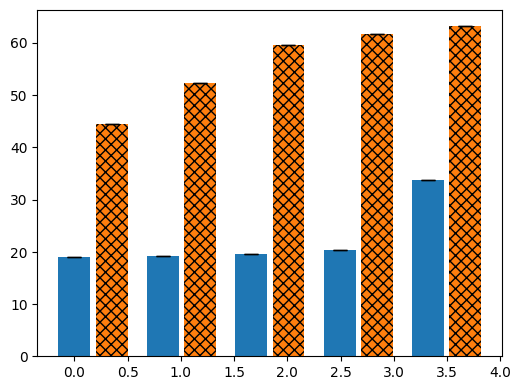

In [78]:
bar_width = 0.3
bar_spacing = 0.05
group_spacing = 0.18
colors = [matplotlibpalette['tab:blue'],matplotlibpalette['tab:orange']]


def getTitle(variant):
    channels = int(re.search(channels_regex, variant).group(1))
    length = int(re.search(length_regex, variant).group(1))
    lfo = int(re.search(lfo_regex, variant).group(1))

    # label = '1x'+str(channels)+'ch '+str(length)+' samples'
    def intToOrdinalString(n):
        if n == 1:
            return '1st'
        elif n == 2:
            return '2nd'
        elif n == 3:
            return '3rd'
        else:
            return str(n)+'th'
    irlenstr = '%d'%(length/48000) if int(length/48000) == length/48000 else '%.2f'%(length/48000)
    import math
    channelsToAmbisonics = lambda ch: math.sqrt(ch)-1

    return 'Real=time ratio for %ss long %s order Ambisonics IRs' % (irlenstr, intToOrdinalString(channelsToAmbisonics(channels)))

for variant, time_data in time_data_bak.items():

    print('-'*80+'\n'+'variant: '+variant+'\n'+'-'*80)
    printVerbose('oldsparta len: '+str({spl:(len(time_data[spl]['OLDsparta']) if 'OLDsparta' in time_data[spl] else 0) for spl in time_data.keys()}))
    printVerbose('spartaMcfx len: '+str({spl:(len(time_data[spl]['spartaMcfx']) if 'spartaMcfx' in time_data[spl] else 0) for spl in time_data.keys()}))


    INPUT_LENGTH_SECONDS = 1000
    averages_OLDsparta = [(spl,np.mean(time_data[spl]['OLDsparta'] if 'OLDsparta' in time_data[spl] else [0])) for spl in time_data.keys()]
    averages_spartaMcfx = [(spl,np.mean(time_data[spl]['spartaMcfx'] if 'spartaMcfx' in time_data[spl] else [0])) for spl in time_data.keys()]

    for i,elem in enumerate(averages_OLDsparta):
        averages_OLDsparta[i] = (elem[0],INPUT_LENGTH_SECONDS/elem[1])
    for i,elem in enumerate(averages_spartaMcfx):
        averages_spartaMcfx[i] = (elem[0],INPUT_LENGTH_SECONDS/elem[1])


    # print('OLDsparta averages: '+str(averages_OLDsparta))
    # print('spartaMcfx averages: '+str(averages_spartaMcfx))
    # break

    nonNanSem = lambda x: stats.sem(x) if len(x) > 1 else 0

    SEMS_OLDsparta = [nonNanSem(time_data[spl]['OLDsparta'])if 'OLDsparta' in time_data[spl] else 0 for spl in time_data.keys()]
    SEMS_spartaMcfx = [nonNanSem(time_data[spl]['spartaMcfx'])if 'spartaMcfx' in time_data[spl] else 0 for spl in time_data.keys()]

    for i,elem in enumerate(SEMS_OLDsparta):
        SEMS_OLDsparta[i] = 0 #1/SEMS_OLDsparta[i]
    for i,elem in enumerate(SEMS_spartaMcfx):
        SEMS_spartaMcfx[i] = 0 #1/SEMS_spartaMcfx[i]

    # print('OLDsparta SEMS: '+str(SEMS_OLDsparta))
    # break

    x_bar_positions = []
    assert len(averages_OLDsparta) == len(averages_spartaMcfx)
    curpos = 0
    for oSp, sMc in zip(averages_OLDsparta,averages_spartaMcfx):
        x_bar_positions.append(curpos)
        curpos += bar_width + bar_spacing
        x_bar_positions.append(curpos)
        curpos += bar_width + group_spacing


    if PLOT_BARS:
        fig, ax = plt.subplots(figsize=DEFFIGSIZE)
        fig.set_figwidth(DEFFIGSIZE[0])
        fig.set_figheight(DEFFIGSIZE[1])
        curpos = 0
        minmax_y = [0,0]
        for oSp, sMc, errOsp, errSMc in zip(averages_OLDsparta,averages_spartaMcfx, SEMS_OLDsparta, SEMS_spartaMcfx):
            print('oSp: '+str(oSp)+' sMc: '+str(sMc))
            spl = oSp[0]
            oSp = oSp[1]
            sMc = sMc[1]
            ax.bar(x_bar_positions[curpos],oSp,bar_width,label=PLUGIN_NAMES['OLDsparta'], color=colors[0],
                yerr=errOsp, capsize=5, hatch=hatches[0])
            # ax.errorbar(x_bar_positions[curpos],oSp,yerr=errOsp, ecolor='k', capsize=bar_width)
            curpos+=1
            ax.bar(x_bar_positions[curpos],sMc,bar_width,label=PLUGIN_NAMES['spartaMcfx'], color=colors[1],
                yerr=errSMc, capsize=5, hatch=hatches[1])
            curpos+= 1
            minmax_y[0] = min(minmax_y[0],oSp+errOsp,sMc+errSMc)
            minmax_y[1] = max(minmax_y[1],oSp-errOsp,sMc-errSMc)

        break

        # ax.set_ylim([minmax_y[0],minmax_y[1]*1.15])
        # set x-ticks for pairwise average position
        xticks = []
        xlabels = []
        for i in range(0,len(list(time_data.keys()))):
            tick = (x_bar_positions[i*2]+x_bar_positions[i*2+1])/2
            label = list(time_data.keys())[i]
            xticks.append(tick)
            xlabels.append(label)
        ax.set_xticks(xticks)
        ax.set_xticklabels(xlabels)

        # ax.set_xticklabels([str(spl) for spl in time_data.keys()])
        #reduce legend to just first two entries
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[:2], labels[:2])

        ax.set_title(getTitle(variant))
        ax.set_xlabel('Audio Block Size [samples]')
        ax.set_ylabel('real-time-ratio')

        assert fig.get_figwidth() ==  DEFFIGSIZE[0]
        assert fig.get_figheight() ==  DEFFIGSIZE[1]
        fig.savefig('../outplots/bars'+variant+'.pdf', bbox_inches='tight')
        fig.savefig('../outplots/bars'+variant+'.png', bbox_inches='tight')
        append_Markdown_png('../README.md','outplots//bars'+variant+'.png')
        plt.show()


    if PLOT_LINES:
        # Now plot both averages_OLDsparta and averages_spartaMcfx as lines+points (two colors and point times)
        fig, ax = plt.subplots(figsize=DEFFIGSIZE)
        fig.set_figwidth(DEFFIGSIZE[0])
        fig.set_figheight(DEFFIGSIZE[1])
        minmax_y = [0,0]

        x = [spl for spl in time_data.keys()]
        y_OLDsparta = [e[1] for e in averages_OLDsparta]
        y_spartaMcfx = [e[1] for e in averages_spartaMcfx]

        ax.plot(x,y_OLDsparta, label=PLUGIN_NAMES['OLDsparta'], color=colors[0], marker='', linestyle='--')
        ax.plot(x,y_spartaMcfx, label=PLUGIN_NAMES['spartaMcfx'], color=colors[1], marker='')
        # plot error brackets corresponding to SEMS
        ax.errorbar(x,y_OLDsparta,yerr=SEMS_OLDsparta, fmt='none', ecolor='k')
        ax.errorbar(x,y_spartaMcfx,yerr=SEMS_spartaMcfx, fmt='none', ecolor='k')

        combined_y = y_OLDsparta + y_spartaMcfx
        combined_err = SEMS_OLDsparta + SEMS_spartaMcfx
        minmax_y[0] = min([combined_y[i]-combined_err[i] for i in range(len(combined_y))])
        minmax_y[1] = max([combined_y[i]+combined_err[i] for i in range(len(combined_y))])

        # MIN_SHOULD_BE_ZERO = True
        # if MIN_SHOULD_BE_ZERO:
        #     ax.set_ylim([0,minmax_y[1]*1.09])
        # else:
        #     ax.set_ylim([minmax_y[0]-(0.05*minmax_y[0]),minmax_y[1]*1.09])
        # x log scale
        # ax.set_xscale('log')

        
        ax.set_title(getTitle(variant))
        ax.set_xlabel('Audio Block Size [samples]')
        ax.set_ylabel('real-time-ratio')

        ax.set_xticks([spl for spl in time_data.keys()])

        ax.legend()

        assert fig.get_figwidth() ==  DEFFIGSIZE[0]
        assert fig.get_figheight() ==  DEFFIGSIZE[1]
        fig.savefig('../outplots/lines'+variant+'.pdf', bbox_inches='tight')
        fig.savefig('../outplots/lines'+variant+'.png', bbox_inches='tight')
        append_Markdown_png('../README.md','outplots//lines'+variant+'.png')
        plt.show()

In [60]:
rtime = 5.02
ttime = 16.40

rtime_sec = time_to_seconds(rtime)
ttime_sec = time_to_seconds(ttime)

print(rtime_sec)
print(ttime_sec)

rt_speedup = ttime_sec/rtime_sec

print('Rendered at %.2fx'%rt_speedup)

print('Real_time ratio %.2f'%(rtime_sec/ttime_sec))
print('Real_time ratio %.2f%%'%((rtime_sec/ttime_sec)*100))
                                  
                            #   seconds_to_percentage(time_to_seconds(t)

302
1000
Rendered at 3.31x
Real_time ratio 0.30
Real_time ratio 30.20%


In [61]:
# allvariants
# allspls
# allplugins

# Now we plot speedups as bars. 
# We compute them for each spl and variant and put variants side by side with the same x-label spl
# We compute speedup as (time_newSparta/time_oldSparta)/real_input_length

assert sorted(allplugins) == ['OLDsparta', 'spartaMcfx'], 'Expected plugins to be OLDsparta and spartaMcfx, but got '+str(allplugins)
allplugins.sort()
allvariants.sort()
allspls.sort()

speedups = {}
for variant in allvariants:
    speedups[variant] = {}
    for spl in allspls:
        speedups[variant][spl] = {}

        if variant in raw_time_data and spl in raw_time_data[variant]:
            pluginisthere = sum([1 for plugin in allplugins if plugin in raw_time_data[variant][spl]])/len(allplugins) == 1
            if pluginisthere:
                timeNew = np.mean(raw_time_data[variant][spl]["spartaMcfx"])
                timeOld = np.mean(raw_time_data[variant][spl]["OLDsparta"])
                timereal_s = 1000

                timeOld_sec = time_to_seconds(timeOld)
                timeNew_sec = time_to_seconds(timeNew)
                speedups[variant][spl] = (timeOld_sec/timeNew_sec)
                print('new: %.2f old: %.2f speedup: %.2f'%(timeNew_sec,timeOld_sec,speedups[variant][spl]))
            else:
                speedups[variant][spl] = 0

# print(speedups)

new: 225.00 old: 525.00 speedup: 2.33
new: 191.00 old: 523.00 speedup: 2.74
new: 168.00 old: 509.00 speedup: 3.03
new: 162.00 old: 491.00 speedup: 3.03
new: 158.00 old: 306.00 speedup: 1.94
new: 101.00 old: 174.00 speedup: 1.72
new: 80.00 old: 166.00 speedup: 2.08
new: 68.00 old: 162.00 speedup: 2.38
new: 65.00 old: 163.00 speedup: 2.51
new: 63.00 old: 116.00 speedup: 1.84
new: 109.00 old: 132.00 speedup: 1.21
new: 91.00 old: 126.00 speedup: 1.38
new: 84.00 old: 136.00 speedup: 1.62
new: 81.00 old: 140.00 speedup: 1.73
new: 93.00 old: 109.00 speedup: 1.17


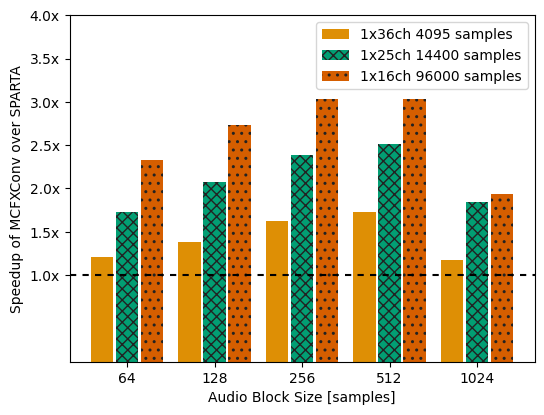

In [62]:
# Plot bars

fig, ax = plt.subplots(figsize=DEFFIGSIZE)
fig.set_figwidth(DEFFIGSIZE[0])
fig.set_figheight(DEFFIGSIZE[1])
bar_width = 0.4
bar_spacing = 0.04
group_spacing = 0.22
# colors = [
#             matplotlibpalette['tab:cyan'],
#             matplotlibpalette['tab:green'],
#             matplotlibpalette['tab:olive'],
#             matplotlibpalette['tab:pink'],
#             matplotlibpalette['tab:brown'],
#             matplotlibpalette['tab:purple'],
#             matplotlibpalette['tab:gray'],
#             matplotlibpalette['tab:blue'],
#             matplotlibpalette['tab:orange'],
#             matplotlibpalette['tab:red'],
# ]

colors = [
            '#029e73',
            '#d55e00',
            '#cc78bc',
            '#ca9161',
            '#fbafe4',
            '#949494',
            '#ece133',
            '#56b4e9',
            '#0173b2',
            '#de8f05',
]
rotateColors = lambda x: x[1:]+[x[0]]
rotateOppositeColors = lambda x: x[-1:]+x[:-1]
colors = rotateOppositeColors(colors)

hatches = ['','xxx','..']


allvariants.sort(reverse=True)

x_bar_positions = []
curpos = 0
xticks = []
xlabels = []
for spl in allspls:
    for variant in allvariants:
        x_bar_positions.append(curpos)
        xticks.append(curpos)
        xlabels.append(str(spl))
        curpos += bar_width + bar_spacing
    curpos += group_spacing

for spl in allspls:
    for vix, variant in enumerate(allvariants):
        speedup = speedups[variant][spl]

        channels = int(re.search(channels_regex, variant).group(1))
        length = int(re.search(length_regex, variant).group(1))
        lfo = int(re.search(lfo_regex, variant).group(1))

        label = '1x'+str(channels)+'ch '+str(length)+' samples'



        ax.bar(x_bar_positions.pop(0),speedup,bar_width,label=label, color=colors[vix%len(colors)], hatch=hatches[vix%len(hatches)], edgecolor='#222222',lw=0.0)

# ax.set_title('Speedup for different variants')
ax.set_xlabel('Audio Block Size [samples]')
ax.set_ylabel('Speedup of MCFXConv over SPARTA')

# take all equal xlabels and put a xtick only in the middle
newxticks = []
newxlabels = []
alllabels = sorted(list((set(xlabels))))
for lab in alllabels:
    newxlabels.append(lab)
    indexes = [i for i, x in enumerate(xlabels) if x == lab]
    newxticks.append(np.mean([xticks[i] for i in indexes]))

ax.set_xticks(newxticks)
ax.set_xticklabels(newxlabels)

# ax.set_ylim([1,3.5])

ax.set_ylim(1,3.7)
# get y tick labels and append 'x'
limy = ax.get_ylim()
roundint = lambda x : int(round(x,0))
ticklabelsy = list(np.arange(roundint(limy[0]),roundint(limy[1]*1.15)+1,0.5))[:-1]
ax.set_yticks(ticklabelsy)
ax.set_yticklabels([str(r)+'x' for r in ticklabelsy])

# Horizontal dashed line at 1.0 speedup
# ax.hlines(y, xmin, xmax, colors=None, linestyles='solid', label='', *, data=None, **kwargs)
# ax.hlines([1.0], ax.get_xlim()[0], ax.get_xlim()[1])




# legend only with variants in allvariants


handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:len(allvariants)], labels[:len(allvariants)])
          
# ax.legend()
# fig.savefig('speedup_bars.pdf', bbox_inches='tight')

assert fig.get_figwidth() ==  DEFFIGSIZE[0]
assert fig.get_figheight() ==  DEFFIGSIZE[1]
fig.savefig('../outplots/speedups.png', bbox_inches='tight')
fig.savefig('../outplots/speedups.pdf', bbox_inches='tight')
append_Markdown_png('../README.md','outplots//speedups.png')



assert fig.get_figwidth() ==  DEFFIGSIZE[0]
assert fig.get_figheight() ==  DEFFIGSIZE[1]
ax.set_ylim(0,4)
ax.axhline(y=1.0,dashes=[3,3], color='k')
fig.savefig('../outplots/speedupsv2.png', bbox_inches='tight')
fig.savefig('../outplots/speedupsv2.pdf', bbox_inches='tight')
append_Markdown_png('../README.md','outplots//speedupsv2.png')


plt.show()


In [63]:
# import platform
# print('processor:',platform.processor())
# print('system:', platform.system())
# import cpuinfo
# cpuinfo.get_cpu_info()['brand']

# run "python ./printCpuInfo.py"
# os.system('python ./printCpuInfo.py')
import subprocess
out = subprocess.check_output(['python', './printCpuInfo.py'])
print(out)


b'Getting CPU Info...\r\nDone!\r\n'
